In [4]:
from xgboost import XGBClassifier
import lightgbm as lgb
from sklearn.metrics import f1_score, recall_score, roc_auc_score, roc_curve, auc
from custom_functions import processing
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFECV
import statistics

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [5]:
file_path = 'P:\DATA_OCT_22\Expert_Eye\Dataset\Data\gait_posture.xlsx'
dataset = pd.read_excel(file_path)
#dataset = dataset.drop(['Foldername'], axis=1)
dataset.shape

(97, 173)

In [7]:
# Models
models = {
    'DecisionTree': DecisionTreeClassifier(class_weight='balanced'),
    'XGBoost': XGBClassifier(scale_pos_weight=2.7),
    'RandomForest': RandomForestClassifier(class_weight='balanced'),
    #'LightGBM': lgb.LGBMClassifier(objective='binary', class_weight='balanced')
}

# Hyperparameters
params = {
    'DecisionTree': {
        'max_depth': [3, 6, 10],
        'max_features': ['sqrt', 'log2'],
        'criterion': ['gini', 'entropy'],
        #'min_samples_leaf': [10],
},        

    'XGBoost': {
        'n_estimators': [30, 50, 100],
        'max_depth': [3, 7, 10],
        'learning_rate': [0.1, 0.2],
        'min_child_weight': [2, 4],
        },

    'RandomForest': {
        'n_estimators': [30, 50, 100],
        'max_depth': [5, 10],
        'max_features': ['sqrt', 'log2'],
        'criterion': ['gini', 'entropy'],
        'bootstrap': [True, False],
        #'max_leaf_nodes': [3, 6, 9]
    },

    #'LightGBM': {
        #'n_estimators': [50, 100],
        #'learning_rate': [0.01, 0.1, 0.2], 
        #'max_depth': [3, 7, 10],
    #}
}

In [ ]:
# Split data
# Use StratifiedKFold to split data into 5 folds and impute missing values
n_splits = 5
model_metrics = {}
tpr_dict = {}  
feature_importances = {model_name: [] for model_name in models.keys()}
selected_features_per_model = {model_name: [] for model_name in models.keys()}

# Features names for 'feature_importances_' attributes
feature_names = dataset.drop(['Fried_State', 'Fried_Score', 'Frailty_State', 'Frailty_Score'], axis=1)

# Features
X = dataset.drop(['Fried_State', 'Fried_Score', 'Frailty_State', 'Frailty_Score'], axis=1).values

# Target variable
y = dataset['Frailty_State'].values

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Loop through each Fold
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]


    # Impute missing values on train set
    X_train_imputed, best_k = processing(X_train, n_splits=n_splits, k_values=[1, 3, 5, 7, 9], verbose=False)

    X_test_imputed, best_k = processing(X_test, n_splits=n_splits, k_values=[1, 3, 5, 7, 9], verbose=False)

    # Loop through each model and perform grid
    for model_name, model in models.items():
        print(f'Performing Grid Search for {model_name}...')

        # Grid search
        grid_search = GridSearchCV(
            estimator=model, 
            param_grid=params[model_name], 
            scoring='roc_auc',
            cv=5, 
            n_jobs=-1, verbose=0)

        # Initialize the metrics for the current model if not already done
        if model_name not in model_metrics:
            model_metrics[model_name] = {
                'f1_score': [],
                'rec_score': [],
                'roc_auc_score': [],
                'best_params' : [],
                'best_models': []
            }

        grid_search.fit(X_train_imputed, y_train)

        # Best parameters
        best_params = grid_search.best_params_
        #print(f'Best Parameters: {best_params}')

        # Best score
        best_score = grid_search.best_score_
        #print(f'Best Score: {best_score}')

        # Best model
        best_model = grid_search.best_estimator_
        #print(f'Best Model: {best_model}')

        # Store the best parameters and model
        model_metrics[model_name]['best_params'].append(best_params)
        model_metrics[model_name]['best_models'].append(best_model)

        # Predictions
        y_pred = best_model.predict(X_test_imputed)

        # Calculate metrics
        y_pred_proba = best_model.predict_proba(X_test_imputed)[:, 1]

        model_metrics[model_name]['f1_score'].append(f1_score(y_test, y_pred, average='weighted'))
        model_metrics[model_name]['rec_score'].append(recall_score(y_test, y_pred, average='weighted'))
        model_metrics[model_name]['roc_auc_score'].append(roc_auc_score(y_test, y_pred_proba))


        # Update TPR list for the model
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        if model_name not in tpr_dict:
          tpr_dict[model_name] = []
        tpr_dict[model_name].append(np.interp(np.linspace(0, 1, 100), fpr, tpr))


        # If the model has feature importances, store them
        if hasattr(best_model, 'feature_importances_'):
          feature_importances[model_name].append(best_model.feature_importances_)


        # Initialize the RFECV 
        selector = RFECV(best_model, step=1, 
                         cv=StratifiedKFold(5), 
                         scoring='roc_auc', 
                         n_jobs=-1, 
                         verbose=0
                         )

        # Fit the RFECV
        selector.fit(X_train_imputed, y_train)

        # Store the selected features
        if model_name not in selected_features_per_model:
          selected_features_per_model[model_name] = []
        selected_features_per_model[model_name].append(feature_names.columns[selector.support_])



In [15]:
print(); print('Optimal # of features: {}'.format(selector.n_features_))
print(); print(np.where(selector.support_ == False)[0])


Optimal # of features: 155

[ 22  65  74  75  81  82  83  88 104 107 113 155 158 165]


In [11]:
# Numbers of best features of each model
best_features = {model_name: [] for model_name in models.keys()}
for model_name, features in selected_features_per_model.items():
    for feature in features:
        best_features[model_name].append(len(feature))

In [12]:
best_features

{'DecisionTree': [68, 22, 125, 55, 12],
 'XGBoost': [2, 3, 5, 39, 19],
 'RandomForest': [128, 9, 139, 169, 155]}

In [14]:
len(feature)

155

In [16]:
# Print the best features
for model_name, features in best_features.items():
    print(f'{model_name}: {statistics.mode(features)}')

    

DecisionTree: 68
XGBoost: 2
RandomForest: 128


In [23]:
# Summarize the selected features for each model
for model_name, selected_features in selected_features_per_model.items():
    print(f"Model: {model_name}")

    # Find the common features selected in all folds
    common_features = set.intersection(*(set(x) for x in selected_features))
    print(f"Commonly selected features across all folds: {common_features}")

    print("=" * 30)


Model: DecisionTree
Commonly selected features across all folds: {'critical_time_Diffusion_ML_YO', 'critical_displacement_Diffusion_ML_YO', 'critical_time_Diffusion_AP_YO', 'short_time_diffusion_Diffusion_AP_YO', 'long_time_diffusion_Diffusion_AP_YO', 'frequency_quotient_Power_Spectrum_Density_AP_YO', 'short_time_scaling_Diffusion_AP_YO', 'long_time_scaling_Diffusion_AP_YO', 'FROPCOM0023', 'critical_displacement_Diffusion_AP_YO', 'long_time_scaling_Diffusion_ML_YO'}
Model: XGBoost
Commonly selected features across all folds: {'FROPCOM0023'}
Model: RandomForest
Commonly selected features across all folds: {'SPPB9', 'mean_distance_Radius_YF', 'Sturdiness', 'energy_content_05_2_Power_Spectrum_Density_ML_YF', 'AvgSpeed', 'FROPCOM0023', 'CycleVariability'}


In [24]:
# Initialize a set to hold all unique selected features across all models and folds
all_selected_features = set()

# Summarize the selected features for each model
for model_name, selected_features in selected_features_per_model.items():
    print(f"Model: {model_name}")

    # Find the common features selected in all folds
    common_features = set.intersection(*(set(x) for x in selected_features))
    print(f"Commonly selected features across all folds: {common_features}")

    # Add these common features to the set of all selected features
    all_selected_features.update(common_features)

    print("=" * 30)

# Now, all_selected_features contains all unique features selected across all models and folds
print("All selected features across all models and folds:")
print(all_selected_features)


Model: DecisionTree
Commonly selected features across all folds: {'critical_time_Diffusion_ML_YO', 'critical_displacement_Diffusion_ML_YO', 'critical_time_Diffusion_AP_YO', 'short_time_diffusion_Diffusion_AP_YO', 'long_time_diffusion_Diffusion_AP_YO', 'frequency_quotient_Power_Spectrum_Density_AP_YO', 'short_time_scaling_Diffusion_AP_YO', 'long_time_scaling_Diffusion_AP_YO', 'FROPCOM0023', 'critical_displacement_Diffusion_AP_YO', 'long_time_scaling_Diffusion_ML_YO'}
Model: XGBoost
Commonly selected features across all folds: {'FROPCOM0023'}
Model: RandomForest
Commonly selected features across all folds: {'SPPB9', 'mean_distance_Radius_YF', 'Sturdiness', 'energy_content_05_2_Power_Spectrum_Density_ML_YF', 'AvgSpeed', 'FROPCOM0023', 'CycleVariability'}
All selected features across all models and folds:
{'critical_time_Diffusion_ML_YO', 'critical_displacement_Diffusion_ML_YO', 'critical_time_Diffusion_AP_YO', 'SPPB9', 'mean_distance_Radius_YF', 'short_time_diffusion_Diffusion_AP_YO', 'St

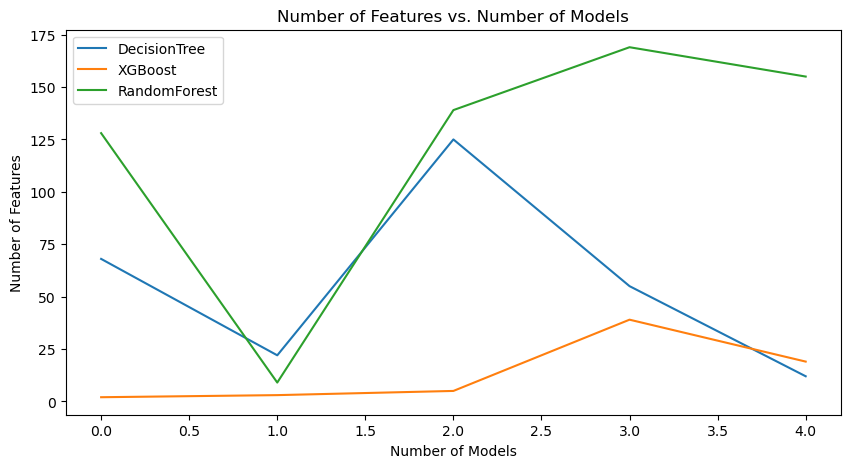

In [17]:
# Plot the number of features vs. the number of models
plt.figure(figsize=(10, 5))
for model_name, features in best_features.items():
    plt.plot(features, label=model_name)
plt.xlabel('Number of Models')
plt.ylabel('Number of Features')
plt.title('Number of Features vs. Number of Models')
plt.legend()
plt.show()

In [ ]:
# Calculate average and std metrics over all folds
metrics_to_avg = ['f1_score', 'rec_score', 'roc_auc_score']

# Calculate average and std metrics over all folds
for model_name in models.keys():
    for metric in metrics_to_avg:  # Update this line
        average_metric = sum(model_metrics[model_name][metric]) / n_splits
        std_metric = statistics.stdev(model_metrics[model_name][metric]) if len(model_metrics[model_name][metric]) > 1 else 0.0
        model_metrics[model_name][metric] = {'average': average_metric, 'std': std_metric}


# Display metrics
for model_name, metrics in model_metrics.items():
    print(f"Model: {model_name}")
    for metric, values in metrics.items():
        print(f"Average {metric}: {values['average']}, {values['std']}")
        print("=" * 30)


# Calculate average TPR over all folds
average_tpr_dict = {}
for model_name in models.keys():
    sum_tpr = np.sum(np.array(tpr_dict[model_name]), axis=0)
    average_tpr = sum_tpr / n_splits
    average_tpr[-1] = 1.0  # ensure the curve ends at 1
    average_tpr_dict[model_name] = average_tpr

# Plot ROC Curve
plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)

for model_name, average_tpr in average_tpr_dict.items():
    average_fpr = np.linspace(0, 1, 100)  # consistent with your np.linspace in the loop
    average_auc = np.trapz(average_tpr, average_fpr)  # Trapezoidal rule for AUC
    plt.plot(average_fpr, average_tpr, label=f"{model_name} (AUC = {average_auc:.2f})")


plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


# Calculate average feature importances and plot them
for model_name, importances in feature_importances.items():
  avg_importance = np.mean(importances, axis=0)
  sorted_idx = np.argsort(avg_importance)[::-1][:20]  # top 20 features

  plt.figure(figsize=(12, 6))
  plt.barh(range(20), avg_importance[sorted_idx])
  plt.yticks(range(20), np.array(feature_names.columns)[sorted_idx])
  plt.xlabel('Average Feature Importance')
  plt.title(f'Average Feature Importance for {model_name}')
  plt.show()


In [21]:
# Features selected across all folds for each model
for model_name, selected_features in selected_features_per_model.items():
  print(f"Model: {model_name}")
  print(f"Selected features: {set.intersection(*map(set, selected_features))}")
  print("=" * 30)

Model: DecisionTree
Selected features: {'critical_time_Diffusion_ML_YO', 'critical_displacement_Diffusion_ML_YO', 'critical_time_Diffusion_AP_YO', 'short_time_diffusion_Diffusion_AP_YO', 'long_time_diffusion_Diffusion_AP_YO', 'frequency_quotient_Power_Spectrum_Density_AP_YO', 'short_time_scaling_Diffusion_AP_YO', 'long_time_scaling_Diffusion_AP_YO', 'FROPCOM0023', 'critical_displacement_Diffusion_AP_YO', 'long_time_scaling_Diffusion_ML_YO'}
Model: XGBoost
Selected features: {'FROPCOM0023'}
Model: RandomForest
Selected features: {'SPPB9', 'mean_distance_Radius_YF', 'Sturdiness', 'energy_content_05_2_Power_Spectrum_Density_ML_YF', 'AvgSpeed', 'FROPCOM0023', 'CycleVariability'}


Training DecisionTree on selected features...
Training XGBoost on selected features...
Training RandomForest on selected features...


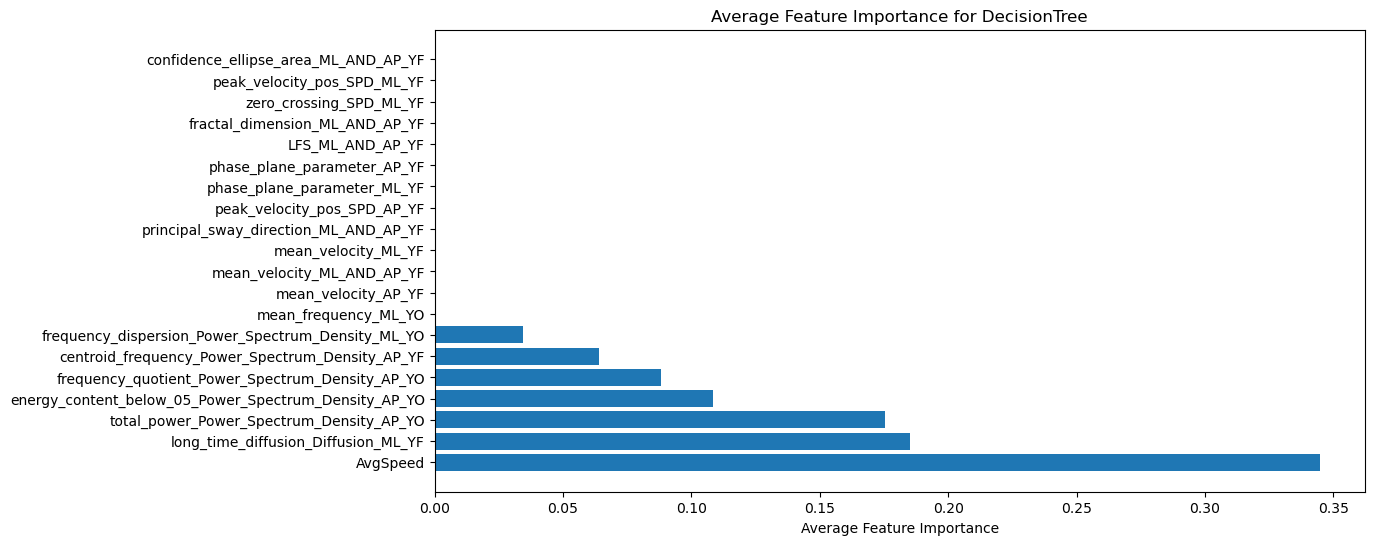

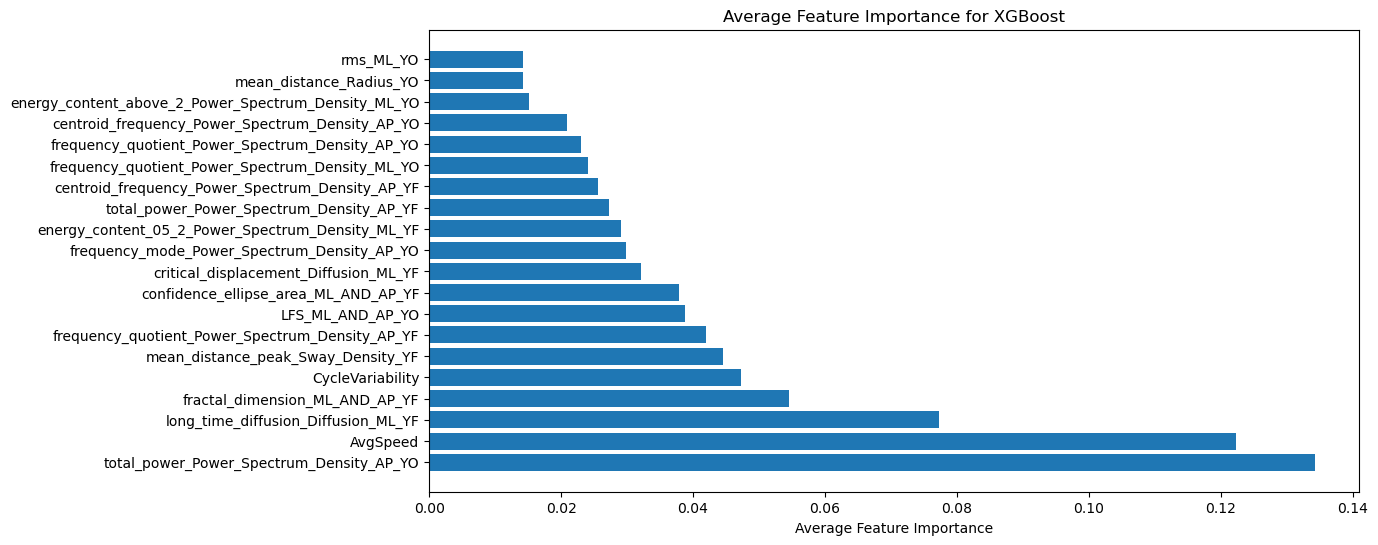

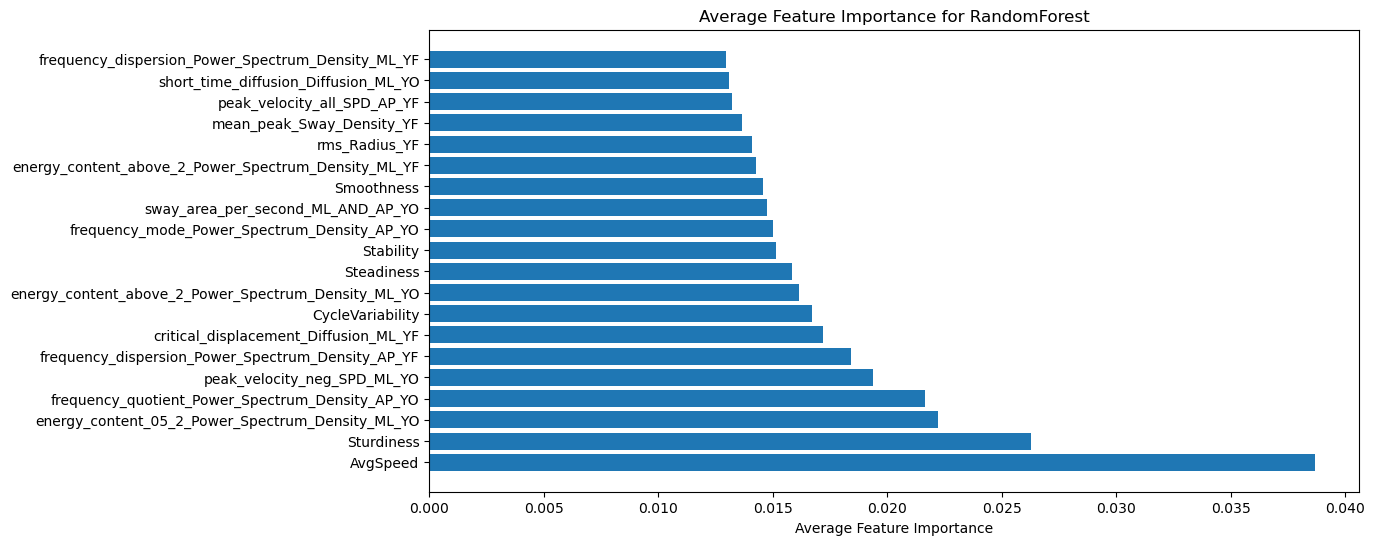

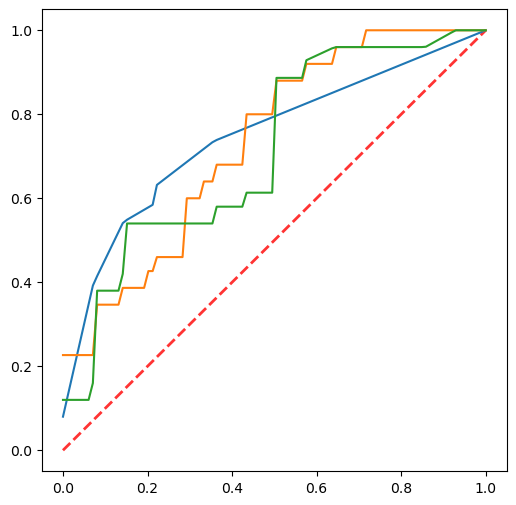

In [20]:
# Train the models on the selected features
for model_name, model in models.items():
    print(f"Training {model_name} on selected features...")
    model.fit(X_train_imputed[:, selector.support_], y_train)

# Calculate average feature importances and plot them
for model_name, model in models.items():
    avg_importance = model.feature_importances_
    sorted_idx = np.argsort(avg_importance)[::-1][:20]  # top 20 features
    
    plt.figure(figsize=(12, 6))
    plt.barh(range(20), avg_importance[sorted_idx])
    plt.yticks(range(20), np.array(feature_names.columns)[sorted_idx])
    plt.xlabel('Average Feature Importance')
    plt.title(f'Average Feature Importance for {model_name}')
    plt.show()

# Calculate average TPR over all folds
average_tpr_dict = {}
for model_name in models.keys():
    sum_tpr = np.sum(np.array(tpr_dict[model_name]), axis=0)
    average_tpr = sum_tpr / n_splits
    average_tpr[-1] = 1.0  # ensure the curve ends at 1
    average_tpr_dict[model_name] = average_tpr

# Plot ROC Curve

plt.figure(figsize=(6, 6))
plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8)

for model_name, average_tpr in average_tpr_dict.items():
    average_fpr = np.linspace(0, 1, 100)  # consistent with your np.linspace in the loop
    average_auc = np.trapz(average_tpr, average_fpr)  # Trapezoidal rule for AUC
    plt.plot(average_fpr, average_tpr, label=f"{model_name} (AUC = {average_auc:.2f})")

    